# SRCNN V1

## Understanding the Dataset

### 1) Installing Dataset

In [2]:
!pip install tacoreader rasterio matplotlib

   ---------------------------------------- 0.0/25.4 MB ? eta -:--:--
   -- ------------------------------------- 1.8/25.4 MB 9.1 MB/s eta 0:00:03
   ----- ---------------------------------- 3.4/25.4 MB 9.1 MB/s eta 0:00:03
   --------- ------------------------------ 5.8/25.4 MB 9.3 MB/s eta 0:00:03
   ----------- ---------------------------- 7.6/25.4 MB 9.2 MB/s eta 0:00:02
   -------------- ------------------------- 9.4/25.4 MB 9.2 MB/s eta 0:00:02
   ----------------- ---------------------- 11.3/25.4 MB 9.2 MB/s eta 0:00:02
   -------------------- ------------------- 13.1/25.4 MB 9.2 MB/s eta 0:00:02
   ----------------------- ---------------- 15.2/25.4 MB 9.2 MB/s eta 0:00:02
   -------------------------- ------------- 17.0/25.4 MB 9.2 MB/s eta 0:00:01
   ----------------------------- ---------- 18.9/25.4 MB 9.2 MB/s eta 0:00:01
   -------------------------------- ------- 21.0/25.4 MB 9.2 MB/s eta 0:00:01
   ----------------------------------- ---- 22.8/25.4 MB 9.2 MB/s eta 0:00:01

In [4]:
!pip install requests aiohttp

### 2) Load a sample using tacoreader

In [7]:
import tacoreader
import rasterio as rio
import matplotlib.pyplot as plt
import numpy as np

# Load the dataset
dataset = tacoreader.load("tacofoundation:sen2naipv2-crosssensor")

# Choose a sample
sample_idx = 3000
lr_ref = dataset.read(sample_idx).read(0)  # Low-res (Sentinel-2-like)
hr_ref = dataset.read(sample_idx).read(1)  # High-res (NAIP)

# Open with rasterio
with rio.open(lr_ref) as src_lr, rio.open(hr_ref) as src_hr:
    lr_data = src_lr.read(window=rio.windows.Window(0, 0, 64, 64))   # 64x64 LR
    hr_data = src_hr.read(window=rio.windows.Window(0, 0, 256, 256)) # 256x256 HR


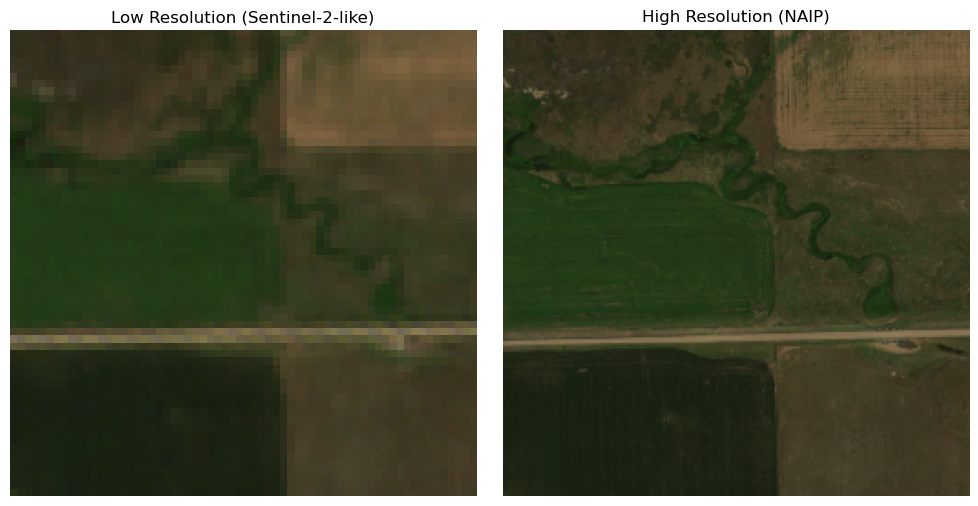

In [8]:
# Display the LR and HR images side-by-side
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Normalize and transpose for plotting (assumes RGB in first 3 bands)
ax[0].imshow(np.clip(lr_data[:3].transpose(1, 2, 0) / 3000.0, 0, 1))
ax[0].set_title("Low Resolution (Sentinel-2-like)")
ax[0].axis("off")

ax[1].imshow(np.clip(hr_data[:3].transpose(1, 2, 0) / 3000.0, 0, 1))
ax[1].set_title("High Resolution (NAIP)")
ax[1].axis("off")

plt.tight_layout()
plt.show()


### 3) Convert to tensors

In [9]:
import torch

# Convert to PyTorch tensors
def to_tensor_gray(data, scale=3000.0):
    rgb = data[:3] / scale  # Normalize
    gray = 0.2989 * rgb[0] + 0.5870 * rgb[1] + 0.1140 * rgb[2]
    tensor = torch.tensor(gray, dtype=torch.float32).unsqueeze(0).unsqueeze(0)  # Shape: [1, 1, H, W]
    return tensor

lr_tensor = to_tensor_gray(lr_data)
hr_tensor = to_tensor_gray(hr_data)

print(f"LR tensor shape: {lr_tensor.shape}, dtype: {lr_tensor.dtype}")
print(f"HR tensor shape: {hr_tensor.shape}, dtype: {hr_tensor.dtype}")

LR tensor shape: torch.Size([1, 1, 64, 64]), dtype: torch.float32
HR tensor shape: torch.Size([1, 1, 256, 256]), dtype: torch.float32


### 4) dataset class for training

In [10]:
from torch.utils.data import Dataset
import torch
import rasterio as rio
import tacoreader
import numpy as np

class Sen2NaipDataset(Dataset):
    def __init__(self, split="tacofoundation:sen2naipv2-crosssensor", indices=None, patch_size=64, scale=4):
        self.dataset = tacoreader.load(split)
        self.indices = indices if indices else range(len(self.dataset))
        self.patch_size = patch_size
        self.scale = scale
        self.hr_patch_size = patch_size * scale

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        sample_idx = self.indices[idx]
        lr_ref = self.dataset.read(sample_idx).read(0)
        hr_ref = self.dataset.read(sample_idx).read(1)

        with rio.open(lr_ref) as src_lr, rio.open(hr_ref) as src_hr:
            # Ensure consistent starting location
            lr_data = src_lr.read(window=rio.windows.Window(0, 0, self.patch_size, self.patch_size))
            hr_data = src_hr.read(window=rio.windows.Window(0, 0, self.hr_patch_size, self.hr_patch_size))

        # Preprocess to grayscale and normalize
        lr_tensor = self.to_tensor_gray(lr_data)
        hr_tensor = self.to_tensor_gray(hr_data)

        return lr_tensor, hr_tensor

    def to_tensor_gray(self, data, norm=3000.0):
        rgb = data[:3] / norm
        gray = 0.2989 * rgb[0] + 0.5870 * rgb[1] + 0.1140 * rgb[2]
        tensor = torch.tensor(gray, dtype=torch.float32).unsqueeze(0)  # [1, H, W]
        return tensor


In [11]:
from torch.utils.data import DataLoader

# Create dataset (using 10 samples for test purposes)
dataset = Sen2NaipDataset(indices=range(10))

# Wrap in DataLoader
loader = DataLoader(dataset, batch_size=1, shuffle=False)

# Iterate
for i, (lr, hr) in enumerate(loader):
    print(f"Sample {i} | LR shape: {lr.shape}, HR shape: {hr.shape}")
    if i == 2: break


Sample 0 | LR shape: torch.Size([1, 1, 64, 64]), HR shape: torch.Size([1, 1, 256, 256])
Sample 1 | LR shape: torch.Size([1, 1, 64, 64]), HR shape: torch.Size([1, 1, 256, 256])
Sample 2 | LR shape: torch.Size([1, 1, 64, 64]), HR shape: torch.Size([1, 1, 256, 256])


### 5) SRCNN class and bicubic

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SRCNN(nn.Module):
    def __init__(self):
        super(SRCNN, self).__init__()
        self.layer1 = nn.Conv2d(1, 64, kernel_size=9, padding=4)
        self.layer2 = nn.Conv2d(64, 32, kernel_size=1, padding=0)
        self.layer3 = nn.Conv2d(32, 1, kernel_size=5, padding=2)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = self.layer3(x)
        return x


In [14]:
import torch.nn.functional as F

# Example upsample (for inference or training)
upsampled = F.interpolate(lr_tensor, scale_factor=4, mode='bicubic', align_corners=False)
output = model(upsampled)


NameError: name 'model' is not defined

### Training

In [5]:
import math

def compute_psnr(output, target, max_pixel=1.0):
    mse = torch.mean((output - target) ** 2)  # Mean Squared Error
    if mse == 0:
        return 100  # Maximum PSNR
    return 20 * math.log10(max_pixel / math.sqrt(mse))


In [18]:
import torch
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the SRCNN model
model = SRCNN().to(device)

# Set up DataLoader (for training and validation)
train_dataset = Sen2NaipDataset(split="tacofoundation:sen2naipv2-unet", indices=range(100))
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()  # Training mode
    running_loss = 0.0

    for i, (lr, hr) in enumerate(train_loader):
        lr, hr = lr.to(device), hr.to(device)

        # Upsample LR image to HR size
        upsampled = F.interpolate(lr, scale_factor=4, mode='bicubic', align_corners=False)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        output = model(upsampled)

        # Compute the loss
        loss = criterion(output, hr)
        loss.backward()  # Backpropagation

        # Update weights
        optimizer.step()

        running_loss += loss.item()

        if (i + 1) % 100 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {running_loss/100:.4f}")
            running_loss = 0.0

    # Compute PSNR after each epoch
    psnr = compute_psnr(output, hr)
    print(f"Epoch [{epoch+1}/{num_epochs}], PSNR: {psnr:.2f} dB")

    # Optionally, save the model after each epoch
    if (epoch + 1) % 5 == 0:
        torch.save(model.state_dict(), f"srcnn_epoch_{epoch+1}.pth")


Epoch [1/10], Step [100/100], Loss: 0.0089
Epoch [1/10], PSNR: 23.59 dB
Epoch [2/10], Step [100/100], Loss: 0.0029
Epoch [2/10], PSNR: 24.19 dB
Epoch [3/10], Step [100/100], Loss: 0.0026
Epoch [3/10], PSNR: 33.41 dB
Epoch [4/10], Step [100/100], Loss: 0.0023
Epoch [4/10], PSNR: 34.09 dB
Epoch [5/10], Step [100/100], Loss: 0.0021
Epoch [5/10], PSNR: 24.73 dB
Epoch [6/10], Step [100/100], Loss: 0.0020
Epoch [6/10], PSNR: 31.18 dB
Epoch [7/10], Step [100/100], Loss: 0.0020
Epoch [7/10], PSNR: 24.32 dB
Epoch [8/10], Step [100/100], Loss: 0.0020
Epoch [8/10], PSNR: 31.76 dB
Epoch [9/10], Step [100/100], Loss: 0.0019
Epoch [9/10], PSNR: 28.71 dB
Epoch [10/10], Step [100/100], Loss: 0.0019
Epoch [10/10], PSNR: 26.32 dB


In [8]:
import matplotlib.pyplot as plt
import random
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Recreate model and load weights
model = SRCNN().to(device)
model.load_state_dict(torch.load("srcnn_epoch_10.pth", map_location=device))
model.eval()

# Pick a random sample from the dataset
random_idx = random.randint(0, len(train_dataset) - 1)
lr, hr = train_dataset[random_idx]

# Move to device
lr = lr.to(device).unsqueeze(0)  # Add batch dimension
hr = hr.to(device).unsqueeze(0)

# Upsample the LR image to HR size using bicubic interpolation
upsampled = F.interpolate(lr, scale_factor=4, mode='bicubic', align_corners=False)

# Pass through the trained SRCNN
with torch.no_grad():
    sr = model(upsampled)

# Move data to CPU and squeeze for visualization
lr_img = lr.squeeze().cpu().numpy()
hr_img = hr.squeeze().cpu().numpy()
sr_img = sr.squeeze().cpu().numpy()

# Plot all three images side-by-side
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(lr_img, cmap='gray')
plt.title("Low-Resolution (Input)")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(hr_img, cmap='gray')
plt.title("High-Resolution (Ground Truth)")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(sr_img, cmap='gray')
plt.title("SRCNN Output")
plt.axis('off')

plt.tight_layout()
plt.show()


C:\Users\fahdg\AppData\Local\Temp\ipykernel_23676\2107326939.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("srcnn_epoch_10.pth", map_l

NameError: name 'train_dataset' is not defined

# All Together

C:\Users\fahdg\AppData\Local\Temp\ipykernel_23676\4183953501.py:137: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=

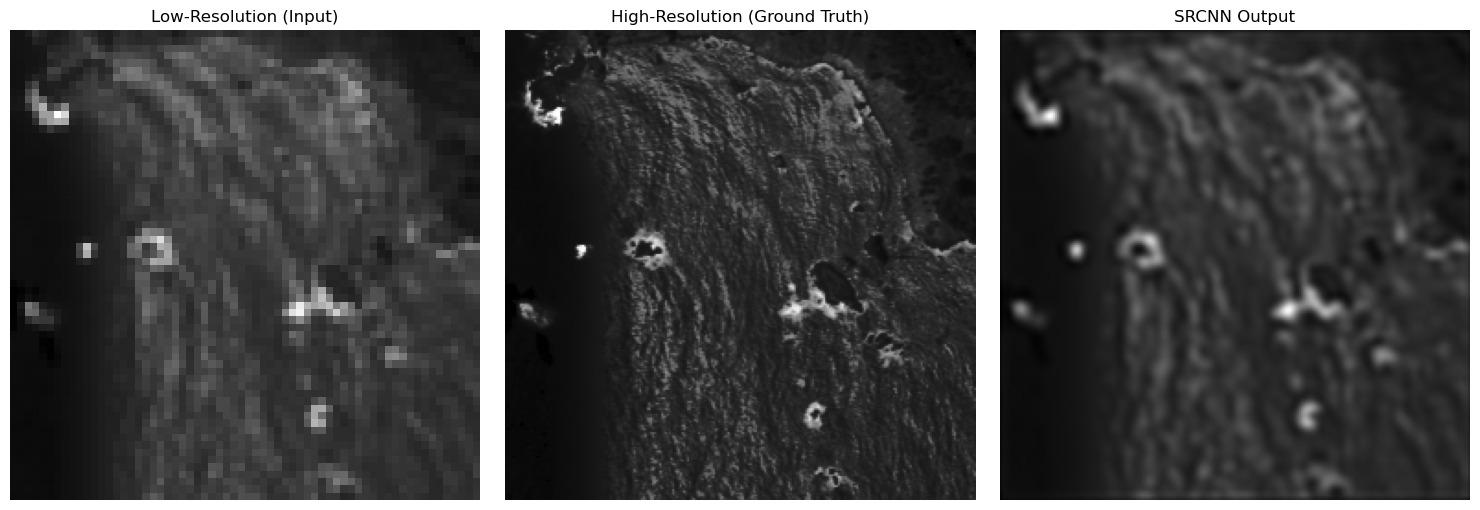

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import tacoreader
import rasterio as rio
import numpy as np
import random
import matplotlib.pyplot as plt
import math
import os

# ---------- 1. Dataset ----------
class Sen2NaipDataset(Dataset):
    def __init__(self, split="tacofoundation:sen2naipv2-unet", indices=None, patch_size=64, scale=4):
        self.dataset = tacoreader.load(split)
        self.indices = indices if indices else range(len(self.dataset))
        self.patch_size = patch_size
        self.scale = scale
        self.hr_patch_size = patch_size * scale

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        sample_idx = self.indices[idx]
        lr_ref = self.dataset.read(sample_idx).read(0)
        hr_ref = self.dataset.read(sample_idx).read(1)

        with rio.open(lr_ref) as src_lr, rio.open(hr_ref) as src_hr:
            lr_data = src_lr.read(window=rio.windows.Window(0, 0, self.patch_size, self.patch_size))
            hr_data = src_hr.read(window=rio.windows.Window(0, 0, self.hr_patch_size, self.hr_patch_size))

        return self.to_tensor_gray(lr_data), self.to_tensor_gray(hr_data)

    def to_tensor_gray(self, data, norm=3000.0):
        rgb = data[:3] / norm
        gray = 0.2989 * rgb[0] + 0.5870 * rgb[1] + 0.1140 * rgb[2]
        return torch.tensor(gray, dtype=torch.float32).unsqueeze(0)  # [1, H, W]


# ---------- 2. Model ----------
class SRCNN(nn.Module):
    def __init__(self):
        super(SRCNN, self).__init__()
        self.layer1 = nn.Conv2d(1, 64, kernel_size=9, padding=4)
        self.layer2 = nn.Conv2d(64, 32, kernel_size=1)
        self.layer3 = nn.Conv2d(32, 1, kernel_size=5, padding=2)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)


# ---------- 3. Training ----------
def compute_psnr(output, target, max_pixel=1.0):
    mse = torch.mean((output - target) ** 2)
    return 100 if mse == 0 else 20 * math.log10(max_pixel / math.sqrt(mse))

def train_model(model, dataloader, device, num_epochs=5, save_path="srcnn_epoch"):
    print("Begin Training")
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for i, (lr, hr) in enumerate(dataloader):
            lr, hr = lr.to(device), hr.to(device)
            upsampled = F.interpolate(lr, scale_factor=4, mode='bicubic', align_corners=False)

            optimizer.zero_grad()
            output = model(upsampled)
            loss = criterion(output, hr)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            if (i + 1) % 100 == 0:
                print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}], Loss: {running_loss/100:.4f}")
                running_loss = 0.0

        psnr = compute_psnr(output, hr)
        print(f"Epoch [{epoch+1}], PSNR: {psnr:.2f} dB")

        if (epoch + 1) % 5 == 0:
            torch.save(model.state_dict(), f"{save_path}_{epoch+1}.pth")
            print(f"model saved as: {save_path}_{epoch+1}.pth")


# ---------- 4. Inference & Visualization ----------
def test_random_sample(model, dataset, device):
    model.eval()
    idx = random.randint(0, len(dataset) - 1)
    lr, hr = dataset[idx]

    lr = lr.unsqueeze(0).to(device)  # Add batch
    hr = hr.unsqueeze(0).to(device)

    upsampled = F.interpolate(lr, scale_factor=4, mode='bicubic', align_corners=False)
    with torch.no_grad():
        sr = model(upsampled)

    # Convert to numpy
    lr_np = lr.squeeze().cpu().numpy()
    hr_np = hr.squeeze().cpu().numpy()
    sr_np = sr.squeeze().cpu().numpy()

    # Plot
    plt.figure(figsize=(15, 5))
    titles = ['Low-Resolution (Input)', 'High-Resolution (Ground Truth)', 'SRCNN Output']
    for i, img in enumerate([lr_np, hr_np, sr_np]):
        plt.subplot(1, 3, i + 1)
        plt.imshow(img, cmap='gray')
        plt.title(titles[i])
        plt.axis('off')
    plt.tight_layout()
    plt.show()


# ---------- 5. Entrypoint ----------
def main(train=True, model_path="srcnn_epoch_10.pth"):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = SRCNN().to(device)

    if train:
        train_dataset = Sen2NaipDataset(indices=range(100))
        train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
        train_model(model, train_loader, device)
    else:
        # Load pretrained weights
        if not os.path.exists(model_path):
            raise FileNotFoundError(f"Model weights not found at {model_path}")
        model.load_state_dict(torch.load(model_path, map_location=device))

        # Load test dataset and run inference
        test_dataset = Sen2NaipDataset(indices=range(10))
        test_random_sample(model, test_dataset, device)

# Run training or testing
# main(train=True)
main(train=False)  # Set to False to test a saved model


# with colour, psnr, and consistent file names

C:\Users\fahdg\AppData\Local\Temp\ipykernel_18168\1993948197.py:155: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=

Test sample index 2 | PSNR: 30.72 dB


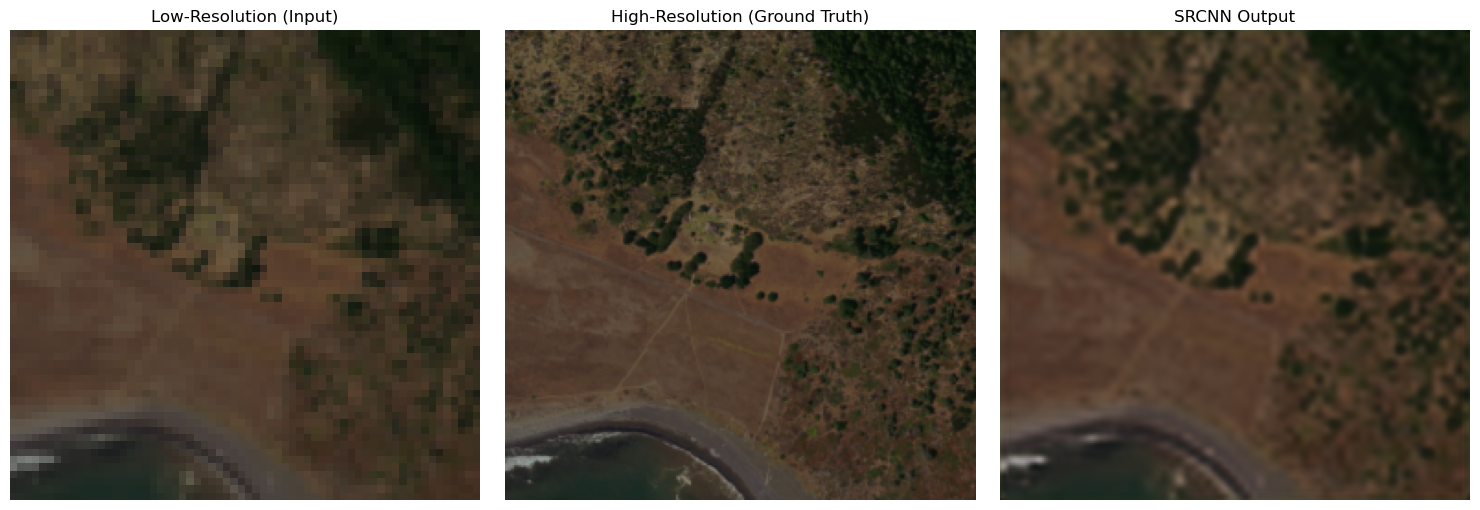

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import tacoreader
import rasterio as rio
import numpy as np
import random
import matplotlib.pyplot as plt
import math
import os

# ---------- 1. Dataset ----------
class Sen2NaipDataset(Dataset):
    def __init__(self, split="tacofoundation:sen2naipv2-unet", indices=None, patch_size=64, scale=4, color=False):
        self.dataset = tacoreader.load(split)
        self.indices = indices if indices else range(len(self.dataset))
        self.patch_size = patch_size
        self.scale = scale
        self.color = color
        self.hr_patch_size = patch_size * scale

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        sample_idx = self.indices[idx]
        lr_ref = self.dataset.read(sample_idx).read(0)
        hr_ref = self.dataset.read(sample_idx).read(1)

        with rio.open(lr_ref) as src_lr, rio.open(hr_ref) as src_hr:
            lr_data = src_lr.read(window=rio.windows.Window(0, 0, self.patch_size, self.patch_size))
            hr_data = src_hr.read(window=rio.windows.Window(0, 0, self.hr_patch_size, self.hr_patch_size))

        if self.color:
            return self.to_tensor_rgb(lr_data), self.to_tensor_rgb(hr_data)
        else:
            return self.to_tensor_gray(lr_data), self.to_tensor_gray(hr_data)

    def to_tensor_gray(self, data, norm=3000.0):
        rgb = data[:3] / norm
        gray = 0.2989 * rgb[0] + 0.5870 * rgb[1] + 0.1140 * rgb[2]
        return torch.tensor(gray, dtype=torch.float32).unsqueeze(0)  # [1, H, W]

    def to_tensor_rgb(self, data, norm=3000.0):
        rgb = data[:3] / norm
        return torch.tensor(rgb, dtype=torch.float32)  # [3, H, W]


# ---------- 2. Model ----------
class SRCNN(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super(SRCNN, self).__init__()
        self.layer1 = nn.Conv2d(in_channels, 64, kernel_size=9, padding=4)
        self.layer2 = nn.Conv2d(64, 32, kernel_size=1)
        self.layer3 = nn.Conv2d(32, out_channels, kernel_size=5, padding=2)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)


# ---------- 3. Training ----------
def compute_psnr(output, target, max_pixel=1.0):
    mse = F.mse_loss(output, target)
    return 100 if mse.item() == 0 else 20 * math.log10(max_pixel / math.sqrt(mse.item()))

def train_model(model, dataloader, device, num_epochs=100, save_path="srcnn_model"):
    print("Training")
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for i, (lr, hr) in enumerate(dataloader):
            lr, hr = lr.to(device), hr.to(device)
            upsampled = F.interpolate(lr, scale_factor=4, mode='bicubic', align_corners=False)

            optimizer.zero_grad()
            output = model(upsampled)
            loss = criterion(output, hr)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            if (i + 1) % 100 == 0:
                print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}], Loss: {running_loss/100:.4f}")
                running_loss = 0.0

        psnr = compute_psnr(output, hr)
        print(f"Epoch [{epoch+1}], PSNR: {psnr:.2f} dB")

        if (epoch + 1) % 5 == 0:
            torch.save(model.state_dict(), f"{save_path}.pth")
            print(f"Model saved as: {save_path}.pth")


# ---------- 4. Inference & Visualization ----------
def test_random_sample(model, dataset, device, color=False):
    model.eval()
    idx = random.randint(0, len(dataset) - 1)
    lr, hr = dataset[idx]
    lr = lr.unsqueeze(0).to(device)
    hr = hr.unsqueeze(0).to(device)

    upsampled = F.interpolate(lr, scale_factor=4, mode='bicubic', align_corners=False)

    with torch.no_grad():
        sr = model(upsampled)

    psnr = compute_psnr(sr, hr)
    print(f"Test sample index {idx} | PSNR: {psnr:.2f} dB")

    # Move to CPU and plot
    def to_np(img):
        return img.squeeze().cpu().numpy()

    if color:
        lr_np = np.transpose(to_np(lr), (1, 2, 0))
        hr_np = np.transpose(to_np(hr), (1, 2, 0))
        sr_np = np.transpose(to_np(sr), (1, 2, 0))
    else:
        lr_np = to_np(lr)
        hr_np = to_np(hr)
        sr_np = to_np(sr)

    plt.figure(figsize=(15, 5))
    titles = ['Low-Resolution (Input)', 'High-Resolution (Ground Truth)', 'SRCNN Output']
    for i, img in enumerate([lr_np, hr_np, sr_np]):
        plt.subplot(1, 3, i + 1)
        plt.imshow(img, cmap=None if color else 'gray')
        plt.title(titles[i])
        plt.axis('off')
    plt.tight_layout()
    plt.show()


# ---------- 5. Entrypoint ----------
def main(train=True, model_path="srcnn_model.pth", color=False):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    in_channels = 3 if color else 1
    model = SRCNN(in_channels=in_channels, out_channels=in_channels).to(device)

    if train:
        train_dataset = Sen2NaipDataset(indices=range(100), color=color)
        train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
        train_model(model, train_loader, device)
    else:
        if not os.path.exists(model_path):
            raise FileNotFoundError(f"Model weights not found at {model_path}")
        model.load_state_dict(torch.load(model_path, map_location=device))

        test_dataset = Sen2NaipDataset(indices=range(10), color=color)
        test_random_sample(model, test_dataset, device, color=color)


# -------- Run here --------
# main(train=True, color=True)  # To train with color
main(train=False, color=True)   # To test with color images and show PSNR
